In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
sns.set(font_scale=1.5) 

import numpy as np
import pandas as pd

from bokeh.layouts import column, row
from bokeh.models import Select, Panel, Tabs, Range1d, LinearAxis
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import show, output_notebook, output_file

output_notebook()

Loading BokehJS ...

In [58]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the values, set the indices, parse the dates, and alphabetize
df = pd.read_csv(url, 
                 header=0, 
                 index_col=['state','county','date'], 
                 parse_dates=True).sort_index()

# List the counties of interest
counties = ['Middlesex', 'Norfolk', 'Suffolk']

# Make a dictionary to store the dataframes of the counties of interest
data = {counties[i] : df.loc[('Massachusetts', counties[i])].drop('fips', axis=1) for i in range(len(counties))}
data

{'Middlesex':             cases  deaths
 date                     
 2020-03-05      1       0
 2020-03-06      1       0
 2020-03-07      5       0
 2020-03-08     10       0
 2020-03-09     15       0
 ...           ...     ...
 2020-08-30  27595    2068
 2020-08-31  27665    2070
 2020-09-01  27732    2071
 2020-09-02  27769    2070
 2020-09-03  25495    2071
 
 [183 rows x 2 columns], 'Norfolk':             cases  deaths
 date                     
 2020-03-02      1       0
 2020-03-03      1       0
 2020-03-04      1       0
 2020-03-05      1       0
 2020-03-06      3       0
 ...           ...     ...
 2020-08-30  11006    1017
 2020-08-31  11033    1018
 2020-09-01  11050    1018
 2020-09-02  11072    1019
 2020-09-03   9597    1021
 
 [186 rows x 2 columns], 'Suffolk':             cases  deaths
 date                     
 2020-02-01      1       0
 2020-02-02      1       0
 2020-02-03      1       0
 2020-02-04      1       0
 2020-02-05      1       0
 ...           ...    

In [62]:
# Find the earliest start date to zero pad the other dates (temporal interpolation)
start = min(data[c].index[0] for c in counties)

# Find the other counties that record data after start
not_earliest = [c for c in counties if data[c].index[0] > start]

# Make them all start at same time
for i, county in enumerate(not_earliest):  
    # make a datetime index of length (first index date - start) days
    idx = pd.date_range(start=start, end=data[county].index[0])[:-1]
    cols = data[county].columns
    vals = np.zeros((len(idx), len(cols)))
    
    # Create the zero pad df
    pad = pd.DataFrame(data=vals, index=idx, columns=cols)
    
    # Glue the zero pad to the beginning of the other dfs
    data[county] = pd.concat([pad, data[county]])

In [63]:
data

{'Middlesex':               cases  deaths
 2020-02-01      0.0     0.0
 2020-02-02      0.0     0.0
 2020-02-03      0.0     0.0
 2020-02-04      0.0     0.0
 2020-02-05      0.0     0.0
 ...             ...     ...
 2020-08-30  27595.0  2068.0
 2020-08-31  27665.0  2070.0
 2020-09-01  27732.0  2071.0
 2020-09-02  27769.0  2070.0
 2020-09-03  25495.0  2071.0
 
 [216 rows x 2 columns], 'Norfolk':               cases  deaths
 2020-02-01      0.0     0.0
 2020-02-02      0.0     0.0
 2020-02-03      0.0     0.0
 2020-02-04      0.0     0.0
 2020-02-05      0.0     0.0
 ...             ...     ...
 2020-08-30  11006.0  1017.0
 2020-08-31  11033.0  1018.0
 2020-09-01  11050.0  1018.0
 2020-09-02  11072.0  1019.0
 2020-09-03   9597.0  1021.0
 
 [216 rows x 2 columns], 'Suffolk':               cases  deaths
 2020-02-01      1.0     0.0
 2020-02-02      1.0     0.0
 2020-02-03      1.0     0.0
 2020-02-04      1.0     0.0
 2020-02-05      1.0     0.0
 ...             ...     ...
 2020-08-30  2

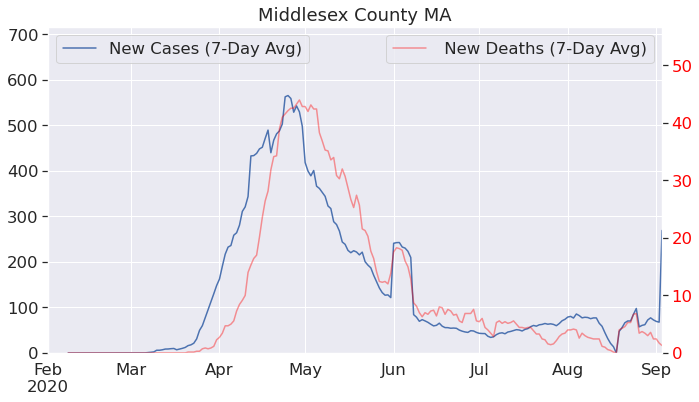

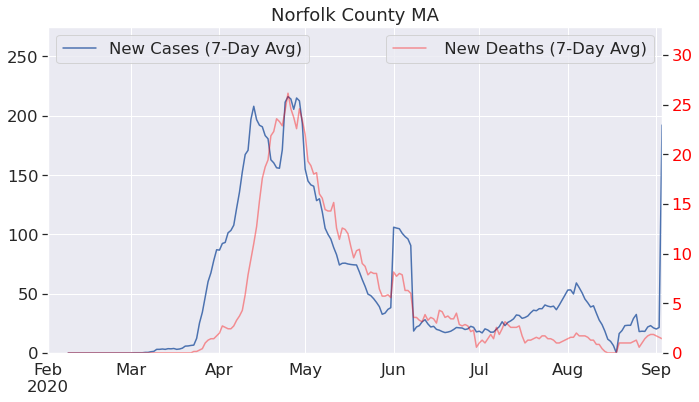

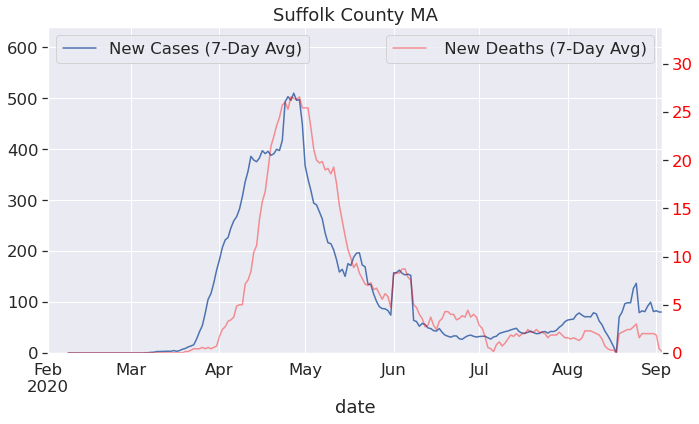

In [41]:
def plotCasesDeaths(dict_of_dfs):
    '''
    Args:
        dict_of_dfs (dictionary): dictionary of dataframes of counties of interest.
                                  Assumes cumulative cases and deaths.
    
    Returns:
        None
        
    Notes:
        Matplotlib style plotting of the cases and deaths using two different
        axes. Uses the .plot() method of a DataFrame
    '''
    for i, county_df in enumerate(dict_of_dfs.values()):    
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
        ax.set_title(counties[i] +' County MA')
        
        # Calculate the daily changes 7 day average
        changes = county_df.diff().rolling(7).mean()
        
        changes.cases.abs().plot(figsize=(11,6), 
                                 ax=ax, 
                                 label='New Cases (7-Day Avg)')
        
        changes.deaths.abs().plot(figsize=(11,6), 
                                  color='red', 
                                  ax=ax2, 
                                  alpha=0.4, 
                                  label=' New Deaths (7-Day Avg)')

        # Make ax2 tick labels the color of the graph
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Set both y-axis limits
        ax2.set_ylim([0,changes.deaths.abs().max() + changes.deaths.abs().std()])
        ax.set_ylim([0,changes.cases.abs().max() + changes.cases.abs().std()])
        
        # Turn off the distracting extra grid
        ax2.grid(False)
        
        # Include the legends
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()
        
plotCasesDeaths(data)

In [ ]:
# Get the daily changes averaged over 7 days
changes_Middlesex = data['Middlesex'].diff().rolling(7).mean()
changes_Norfolk = data['Norfolk'].diff().rolling(7).mean()
changes_Suffolk = data['Suffolk'].diff().rolling(7).mean()

***
http://www.mwra.com/biobot/biobotdata.htm

In [25]:
# Read the values, set the indices, parse the dates, and alphabetize
sew_df = pd.read_csv('../data/sewage_surveillance.csv',
                     header=0, 
                     index_col=[0], 
                     parse_dates=True).sort_index()

# Map to the original data as shown in the link
sew_df = sew_df[sew_df > 0]

ns = ['Northern', 'North_avg']
ss = ['Southern', 'South_avg']
northern = sew_df[ns]
southern = sew_df[ss]

sew_df.head()

,Northern,Southern,North_avg,South_avg
2020-03-11,15.0,22.0,18.0,14.0
2020-03-12,NaN,5.0,18.0,13.0
2020-03-13,NaN,12.0,18.0,13.0
2020-03-14,18.0,16.0,18.0,15.0
2020-03-15,21.0,23.0,19.0,14.0


***
Begin Bokeh plotting

In [39]:
###############################################################################################
# 'Middlesex'
###############################################################################################
p1 = figure(x_axis_type='datetime', 
            x_axis_label='Date', 
            y_axis_label='Daily Changes',
            y_range=(0, changes_Middlesex.cases.max()),
            title='COVID-19 Cases and Deaths')

# Setting the second y axis range name and range
p1.extra_y_ranges = {"New deaths": Range1d(start=0, end=changes_Middlesex.deaths.max())}

# Adding the second axis to the plot.  
p1.add_layout(LinearAxis(y_range_name="New deaths"), 'right')

p1.line(changes_Middlesex.index, 
        changes_Middlesex.cases, 
        color='blue', 
        legend_label='New cases')

p1.line(changes_Middlesex.index, 
        changes_Middlesex.deaths, 
        color='red', 
        y_range_name='New deaths', 
        legend_label='New deaths')

###############################################################################################
# 'Norfolk'
###############################################################################################
p2 = figure(x_axis_type='datetime', 
            x_axis_label='Date', 
            y_axis_label='Daily Changes',
            y_range=(0, changes_Norfolk.cases.max()),
            title='COVID-19 Cases and Deaths')

# Setting the second y axis range name and range
p2.extra_y_ranges = {"New deaths": Range1d(start=0, end=changes_Norfolk.deaths.max())}

# Adding the second axis to the plot.  
p2.add_layout(LinearAxis(y_range_name="New deaths"), 'right')

p2.line(changes_Norfolk.index, 
        changes_Norfolk.cases, 
        color='blue', 
        legend_label='New cases')

p2.line(changes_Norfolk.index, 
        changes_Norfolk.deaths, 
        color='red', 
        y_range_name='New deaths', 
        legend_label='New deaths')

###############################################################################################
# 'Suffolk'
###############################################################################################
p3 = figure(x_axis_type='datetime', 
            x_axis_label='Date', 
            y_axis_label='Daily Changes',
            y_range=(0, changes_Suffolk.cases.max()),
            title='COVID-19 Cases and Deaths')

# Setting the second y axis range name and range
p3.extra_y_ranges = {"New deaths": Range1d(start=0, end=changes_Suffolk.deaths.max())}

# Adding the second axis to the plot.  
p3.add_layout(LinearAxis(y_range_name="New deaths"), 'right')

p3.line(changes_Suffolk.index, 
        changes_Suffolk.cases, 
        color='blue', 
        legend_label='New cases')

p3.line(changes_Suffolk.index, 
        changes_Suffolk.deaths, 
        color='red', 
        y_range_name='New deaths', 
        legend_label='New deaths')

# Set the legend for all the figures
for p in [p1, p2, p3]:
    p.legend.location = 'top_right'
    
# Create tab1 from plot p1: tab1
tab1 = Panel(child=p1, title ='Middlesex County')

# Create tab2 from plot p2: tab2
tab2 = Panel(child=p2, title ='Norfolk County')

# Create tab3 from plot p3: tab3
tab3 = Panel(child=p3, title ='Suffolk County')

tabs = Tabs(tabs=[tab1, tab2, tab3])

###############################################################################################    
# Add viral RNA data figures
###############################################################################################

# Northern
p1_sew = figure(x_axis_type='datetime', 
                x_axis_label='Date', 
                y_axis_label='RNA copies/mL',
                y_range=(0, northern.Northern.max()),
                title='DITP Viral RNA Signal')   
p1_sew.circle(northern.index, northern.Northern, legend_label='Northern')
p1_sew.circle(northern.index, northern.Northern)
p1_sew.line(northern.index, northern.North_avg.interpolate(), color='orange', legend_label='North_avg')
 
# Southern
p2_sew = figure(x_axis_type='datetime', 
                x_axis_label='Date', 
                y_axis_label='RNA copies/mL',
                y_range=(0, southern.Southern.max()),
                title='DITP Viral RNA Signal') 
p2_sew.circle(southern.index, southern.Southern, legend_label='Southern')
p2_sew.circle(southern.index, southern.South_avg)
p2_sew.line(southern.index, southern.South_avg.interpolate(), color='orange', legend_label='South_avg')

# Create tab1 from plot p1: tab1
tab1_sew = Panel(child=p1_sew, title ='Northern')

# Create tab2 from plot p2: tab2
tab2_sew = Panel(child=p2_sew, title ='Southern')

tabs_sew = Tabs(tabs=[tab1_sew, tab2_sew])

# Set the legend for all the figures
for p in [p1_sew, p2_sew]:
    p.legend.location = 'top_right'

###############################################################################################
# set the layout, output the graphs to an html file, and show the graphs
layout = row(tabs, tabs_sew)
output_file('tabbed.html')
show(layout)